<a href="https://colab.research.google.com/github/lavrovaliz/dlab-scripts/blob/main/AI4I_Radiomics_Beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radiomics for beginners
  
<b>'Data curation is the most laborious and boring step of the radiomics workflow' - anyone who has ever worked with radiomics</b>

## Introduction

In this script, you will use an open-source dataset of 422 NSCLC cancer patients named NSCLC Radiomics in TCIA https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics, also known as MAASTRO-Lung-1 (Aerts, H. J. W. L., Wee, L., Rios Velazquez, E., Leijenaar, R. T. H., Parmar, C., Grossmann, P., Carvalho, S., Bussink, J., Monshouwer, R., Haibe-Kains, B., Rietveld, D., Hoebers, F., Rietbergen, M. M., Leemans, C. R., Dekker, A., Quackenbush, J., Gillies, R. J., Lambin, P. (2019). Data From NSCLC-Radiomics [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI), Attribution-NonCommercial 3.0 Unported license (https://creativecommons.org/licenses/by-nc/3.0/). You will build a classifier to differentiate contast-enhanced from non-contrast-enhanced lung CT scans using radiomic features extracted from the GTV. Incredibly, these data were originally (and still are) used without this differentiation, leading to poor model performance for clinical outcomes. Such classifying models can easily help you curate your dataset or add a new label to your list of predictors.

<b>Brief description</b>

Iodinated contrast agents can be used for obtaining a CT image depending on the clinical question that one wants to address. The purpose of such agents can be to enhance the contrast resolution between a lesion/ischemic or occluded region and the normally perfused surrounding tissues. 
Sometimes contrast-enhanced CT is desireable, though the patient has an absolute contra-indication for contrast, such as: 
* allergy to intravenous contrast media, 
* pregnancy (particularly in the first trimester), 
* severe renal impairment,
* hyperthyroidism/goitre (IV contrast might induce thyrotoxic crisis), etc.    

The task of assessing whether an image is contrast-enhanced is <b>fairly easy in early/late arterial phases</b> (major arteries appear as hyperdense, white structures immediately after contrast bolus is administered through a peripheral vein), but may become <b>more challenging in the late portal phase</b> (blood supply from arteries reaches the liver and from there goes back into the venous system through the portal vein) and delayed venous phases (most contrast washes out from the tissue and is filtered through the kidneys).<br>  

| ![picture](https://drive.google.com/uc?export=view&id=1w288Lda5tI6_4sy3sFepgGX4HB0YYm-z)      | ![picture](https://drive.google.com/uc?export=view&id=1Kw47_0GUdvFwPjvjcGW588SGMXuV9TpF)                                                                                         |
|:-----------------------------------------------------------------------------------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| Patient without contrast-enhancement and with a mass in the right upper lobe<br>(red circle) | Patient with contrast enhancement (upper red circle); <br>both the major chambers/arteries of the heart as well as the aorta (arrow) <br>appear as hyperdense white structures |

<b>Problem</b>  

Usually information about the contrast is <b>not included in the DICOM tags</b>, and manual assesment of the CT for the purpose of the data curation can take considerable time. In this task, we are adressing this problem by using radiomics of the GTV to classify the images. The ground truth labelling was performed by a radiology expert. 

<b>Notebook structure</b>  

This Python script will take you through the radiomics analysis steps where you'll learn how to read in the features, select the features, train the models and display the results:
 - installing packages and importing libraries,  
 - preparation of the imaging data,
 - features extraction,
 - reading the data and assigning outcomes, 
 - exploring the data, 
 - removing highly correlated features, 
 - selecting features using recursive feature elimination, 
 - creating the classification models, displaying the results.

## Getting started

This is an interactive Python notebook. To run it, you don't need to install anything on your PC since the script is executed in the cloud. On the left tab, you can see the 'Files' folder, that contains the data. Results of the script execution will be saved in this folder.  
  
The curated imaging dataset is available in the shared Google folder: https://drive.google.com/drive/folders/1R1ipuVU_3Deqr9Lqp_4G8qVZxBEuLMDw?usp=sharing. The dataset is open-source, so you can download the data to have a look at it. It you don't have any software to open DICOM files, you can download and install 3D Slicer (https://www.slicer.org/), RadiAnt viewer (https://www.radiantviewer.com/), or MicroDicom viewer (https://www.microdicom.com/downloads.html). As feature extraction process takes time, we prepared the .csv tables with the pre-extracted features to work with. They are available at the same shared folder. To make the folder accessable for your notebook, right-click it and select 'Add to My Drive'. In the pop-up window, put the label into 'My Drive' location. After mounting your Google Drive (will be explained later), you will have an access to these files.

Please note, that all the files you upload to this notebook as well as the files, produced while executing the script, are automatically deleted as soon as you end the session. The .csv tables of the pre-extracted features are available in this notebook.

First of all, the needed Python packages have to be uploaded. Some of them are not installed in the environment of this notebook, so the installation is needed with '!pip install <i>name-of-the-package</i>' command. We recommend you get acquainted with getting documentation and help on these packages. For example, google 'python sklearn' and you will get to the documentation quickly. Importing libraries is a necessary step with most progamming languages, not only Python.

In [2]:
# installing some packages, which are not part of the present Google Collab environment

!pip install precision-medicine-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import numpy as np
import pandas as pd
from pmtool.AnalysisBox import AnalysisBox
from pmtool.ToolBox import ToolBox
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import xgboost as xgb



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Feature extraction
There are many softwares to perform this step, each with their strengths and weaknesses. Features extraction step takes the longest time, so we are happy to help you with it. We will supply you with "something we prepared earlier", the lists of features already extracted with Radiomics software, and outcomes (CE/non-CE). The data is already split into train and validation sets. Therefore, you can skip this step or return to it later. If you want to skip this step, please move to 'Reading the data' step.  

If you want to extract the features by yourself anyway, you can execute the following code. Here we perform features extraction with PyRadiomics software (https://pyradiomics.readthedocs.io/en/latest/) with the precision-medicine-toolbox (https://github.com/primakov/precision-medicine-toolbox) interface. These are the open-source Python packages.  

First of all, we would need to convert DICOM data into NRRD. But we will start with unzipping the imaging archive.

In [5]:
# this is where we mount a Google Drive

from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# listing the DICOM dataset parameters:
parameters = {'data_path': '/content/drive/MyDrive/AI4I_Radiomics_Beginners_Data/data_dicom', # path to your DICOM data
              'data_type': 'dcm', # original data format: DICOM
              'multi_rts_per_pat': False}   # when False, it will look only 
                                            # for 1 rtstruct in the patient folder, 
                                            # this will speed up the process, 
                                            # if you have more then 1 rtstruct per patient,
                                            # set it to True

# initializing the dataset object:
data_dcms = ToolBox(**parameters)

# getting the description for the first 10 files:
dataset_description = data_dcms.get_dataset_description('CT') 
dataset_description.head(10)

Patients processed: 100%|██████████| 26/26 [01:09<00:00,  2.69s/it]


,PatientName,ConvolutionKernel,SliceThickness,PixelSpacing,KVP,Exposure,XRayTubeCurrent,SeriesDate,patient,slice#
0,"(2, 8, 2, 6, 8, 2, 8, 7, 1, 4)",B30f,3.0,"[0.9765625, 0.9765625]",140.0,400,80,20060420,LUNG1-109_/Unknown (0001),0
1,"(2, 8, 2, 6, 8, 2, 8, 7, 1, 4)",B30f,3.0,"[0.9765625, 0.9765625]",140.0,400,80,20060420,LUNG1-109_/Unknown (0001),1
2,"(2, 8, 2, 6, 8, 2, 8, 7, 1, 4)",B30f,3.0,"[0.9765625, 0.9765625]",140.0,400,80,20060420,LUNG1-109_/Unknown (0001),2
3,"(2, 8, 2, 6, 8, 2, 8, 7, 1, 4)",B30f,3.0,"[0.9765625, 0.9765625]",140.0,400,80,20060420,LUNG1-109_/Unknown (0001),3
4,"(2, 8, 2, 6, 8, 2, 8, 7, 1, 4)",B30f,3.0,"[0.9765625, 0.9765625]",140.0,400,80,20060420,LUNG1-109_/Unknown (0001),4
5,"(2, 8, 2, 6, 8, 2, 8, 7, 1, 4)",B30f,3.0,"[0.9765625, 0.9765625]",140.0,400,80,20060420,LUNG1-109_/Unknown (0001),5
6,"(2, 8, 2, 6, 8, 2, 8, 7, 1, 4)",B30f,3.0,"[0.9765625, 0.9765625]",140.0,400,80,20060420,LUNG1-109_/Unknown (0001),6
7,"(2, 8, 2, 6, 8, 2, 8, 7, 1, 4)",B30f,3.0,"[0.9765625, 0.9765625]",140.0,400,80,20060420,LUNG1-109_/Unknown (0001),7
8,"(2, 8, 2, 6, 8, 2, 8, 7, 1, 4)",B30f,3.0,"[0.9765625, 0.9765625]",140.0,400,80,20060420,LUNG1-109_/Unknown (0001),8
9,"(2, 8, 2, 6, 8, 2, 8, 7, 1, 4)",B30f,3.0,"[0.9765625, 0.9765625]",140.0,400,80,20060420,LUNG1-109_/Unknown (0001),9


We can plot some scanning parameters:

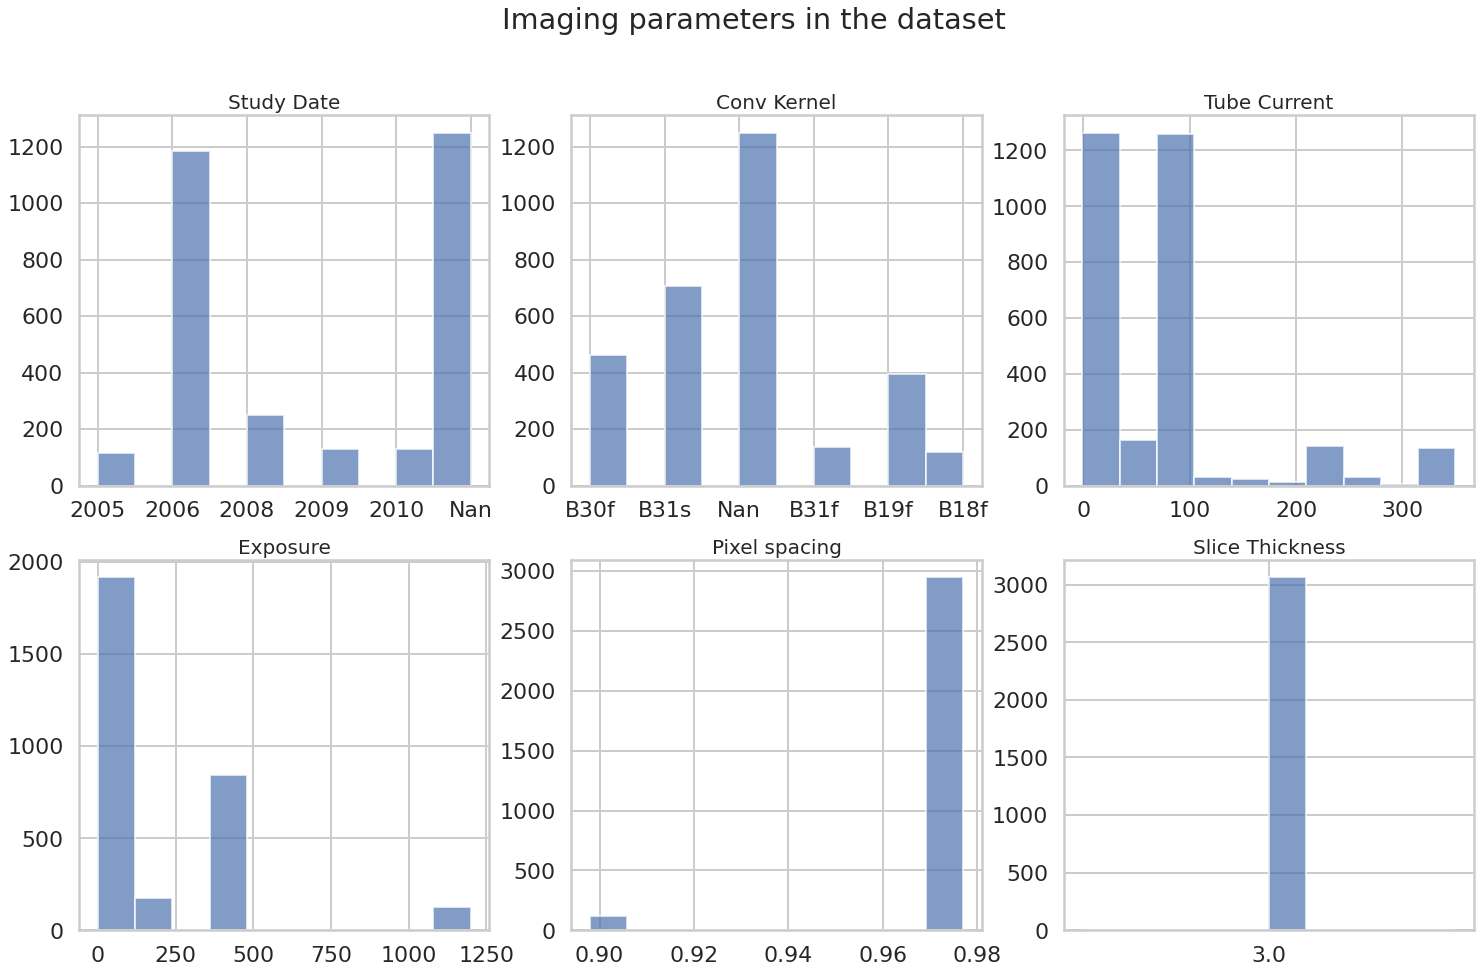

In [5]:
sns.set(context='poster', style='whitegrid')

study_date = sorted([ 'Nan' if x=='' or x=='NaN' else str(x[0:4]) for x in list(dataset_description['SeriesDate'])])[2:]
conv_kernel =['Nan' if x=='' or x=='NaN' else x for x in list(dataset_description['ConvolutionKernel'])]
tube_current =[-1 if x=='' or x=='NaN' else x for x in list(dataset_description['XRayTubeCurrent'])]
exposure =[-1 if x=='' or x=='NaN' else x for x in list(dataset_description['Exposure'])]
ps = sorted([(x[0]) for x in list(filter(lambda x: x != 'NaN', dataset_description['PixelSpacing'].values))])
sl_th = sorted([str(x)[0:3] for x in list(filter(lambda x: x != 'NaN', dataset_description['SliceThickness'].values))])
figures,descriptions = [study_date,conv_kernel,tube_current,exposure,ps,sl_th],['Study Date','Conv Kernel','Tube Current','Exposure','Pixel spacing','Slice Thickness']

fig,ax = plt.subplots(2,3,figsize=(25,15))
for i in range(2):
    for j in range(3):
        ax[i,j].hist(figures.pop(0),alpha=0.7)
        ax[i,j].set_title(descriptions.pop(0),fontsize=20)
        
plt.suptitle('Imaging parameters in the dataset')
plt.show()

As PyRadiomics do not support DICOM, we convert images and masks into NRRD format:

In [6]:
data_dcms.convert_to_nrrd('/content/', 'gtv')

Patients converted: 100%|██████████| 26/26 [00:40<00:00,  1.55s/it]


The data is saved in temporary folder and will be lost as soon as you reboot the notebook! We can read the NRRD data and get sure the convertion was correct and the images are co-aligned with the masks:

In [ ]:
# initializing the newly created NRRD dataset:
data_nrrds = ToolBox(data_path = '/content/converted_nrrds', 
                     data_type='nrrd')

# saving snapshots to JPEG files
data_nrrds.get_jpegs('/content/')

Patients processed:  16%|█▌        | 4/25 [01:02<05:27, 15.60s/it]/usr/local/lib/python3.7/dist-packages/pmtool/ToolBox.py:100: UserWarning: Something wrong with LUNG1-001__GTV-1_mask
  warn('Something wrong with %s'%pat)
Patients processed:  20%|██        | 5/25 [01:10<04:21, 13.09s/it]/usr/local/lib/python3.7/dist-packages/pmtool/ToolBox.py:100: UserWarning: Something wrong with LUNG1-114__GTV-1_mask
  warn('Something wrong with %s'%pat)
Patients processed:  24%|██▍       | 6/25 [01:11<02:50,  8.97s/it]/usr/local/lib/python3.7/dist-packages/pmtool/ToolBox.py:100: UserWarning: Something wrong with LUNG1-052__GTV-1_mask
  warn('Something wrong with %s'%pat)
Patients processed:  28%|██▊       | 7/25 [01:12<01:51,  6.17s/it]

A quick look at the contours:

In [1]:
from ipywidgets import interact
import numpy as np
from PIL import Image

def browse_images(images,names):
    n = len(images)
    def view_image(i):
        plt.figure(figsize=(20,10))
        plt.imshow(images[i])#, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Slice: %s' % names[i])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))

for pat,_ in data_nrrds:
    _,file_struct = [*os.walk(os.path.join('/content/images_quick_check/',pat))]
    root,images = file_struct[0],file_struct[2]
    imgs =[np.array(Image.open(os.path.join(root,img))) for img in images]
    print(pat)
    browse_images(imgs,images)
    break

NameError: ignored

In the precision-medicine-toolbox, we are using PyRadiomics software (https://pyradiomics.readthedocs.io/en/latest/) to extract the features. You can read the full documentation for the currently stable version: https://pyradiomics.readthedocs.io/_/downloads/en/stable/pdf/.

We are using PyRadiomics parameters file customized for CT data:

In [ ]:
parameters = "/content/drive/MyDrive/AI4I_Radiomics_Beginners_Data/example_ct_parameters.yaml"
features = data_nrrds.extract_features(parameters)

Patients processed: 100%|██████████| 25/25 [04:37<00:00, 11.10s/it]


Let's have a look at the dataframe with he features:

In [ ]:
features.head(10)

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,wavelet-LLL_gldm_HighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceEmphasis,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,Patient,ROI
0,v3.0.1,1.21.6,2.1.1.2,1.3.0,3.7.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}}",1defc93a87744cc78261e1851adeb078a8536325,3D,"(0.9765625, 0.9765625, 3.0)",...,15382.37291495537,49.470313783472974,820361.7806582334,0.003213826535937308,0.00013104252483705562,0.21493736161754748,2611.8525474838516,5.390994439636723e-05,LUNG1-109__/content/drive/MyDrive/AI4I_Radiomi...,/content/drive/MyDrive/AI4I_Radiomics_Beginner...
1,v3.0.1,1.21.6,2.1.1.2,1.3.0,3.7.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}}",f5a64efb3d255ae628ffee2afc1091f33d6b4be3,3D,"(0.9765625, 0.9765625, 3.0)",...,11424.937163447912,25.50589092675817,365557.81250253046,0.0019222977107221824,0.00014650126466682128,0.37142848874622025,3237.59491355631,8.62486240125301e-05,LUNG1-113__/content/drive/MyDrive/AI4I_Radiomi...,/content/drive/MyDrive/AI4I_Radiomics_Beginner...
2,v3.0.1,1.21.6,2.1.1.2,1.3.0,3.7.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}}",87a0b82a8ae8952c2c9f983de266ea36bcc99e41,3D,"(0.9765625, 0.9765625, 3.0)",...,6526.772815533981,4.668608414239483,46546.384466019415,0.0021760043351021427,0.0014470563582585222,0.6728499784784983,3554.6204310572184,0.0013271134117182374,LUNG1-098__/content/drive/MyDrive/AI4I_Radiomi...,/content/drive/MyDrive/AI4I_Radiomics_Beginner...
3,v3.0.1,1.21.6,2.1.1.2,1.3.0,3.7.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}}",492a721b5f9041e483128b7ff8234188ae3fd740,3D,"(0.9765625, 0.9765625, 3.0)",...,7213.2603850050655,10.179331306990882,103931.30091185411,0.001936819438556479,0.0007380977646234272,0.5505141320158502,3226.2736170409753,0.0006269034691349227,LUNG1-114__/content/drive/MyDrive/AI4I_Radiomi...,/content/drive/MyDrive/AI4I_Radiomics_Beginner...
4,v3.0.1,1.21.6,2.1.1.2,1.3.0,3.7.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}}",0a271cd35ead443e1037e2d026317c22406d6302,3D,"(0.9765625, 0.9765625, 3.0)",...,12120.948355242268,62.790601384390676,756991.9769130629,0.005391095398416303,0.00012172705086869571,0.13701687025275927,1687.1171404294137,3.267825946044915e-05,LUNG1-105__/content/drive/MyDrive/AI4I_Radiomi...,/content/drive/MyDrive/AI4I_Radiomics_Beginner...
5,v3.0.1,1.21.6,2.1.1.2,1.3.0,3.7.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}}",282e69755d37648beda562786f7d776fb193b490,3D,"(0.977, 0.977, 3.0)",...,13798.217593137668,153.2623496762257,2143507.828368794,0.010978165894795914,8.267286538620663e-05,0.057325663977585324,701.1208896940113,1.4002802720821606e-05,LUNG1-095__/content/drive/MyDrive/AI4I_Radiomi...,/content/drive/MyDrive/AI4I_Radiomics_Beginner...
6,v3.0.1,1.21.6,2.1.1.2,1.3.0,3.7.13,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}}",5e6c47eaa496681db64be7baa116bec927b04448,3D,"(0.9765625, 0.9765625, 3.0)",...,9778.187949718249,25.576159514521024,377340.03883831814,0.00332251206469015,0.0005218742688938506,0.481002952868549,3342.8889330127363,0.00025176428502024436,LUNG1-084__/content/drive/MyDrive/AI4I_Radiomi...,/content/drive/MyDrive/AI4I_Radiomics_Beginner...
7,v3.0.1,1.21.6,2.1.1.2,1.3.0,3.7.13,"{'minimumROIDimens

Now you know how to extract features. Nevertheless, in the prepared files, we also have an expert's outcome (CE/non-CE), therefore, from now on, we recommend to use those .csv files. Moreover, we selected only one ROI per patient (GTV) and the patients were splitted into training and testing sets. The key difference is that the present script is using Pyradiomics for feature extraction whereas in the prepared files, Radiomics software (https://radiomics.bio/) was used.

## Reading the data 

For this step, you will need to upload the feature dataframes to the 'Files' of this notebook and specify the path to these files containing the features and outcomes (in this case 0 or 1 for CE/non-CE). We have already cleaned the dataset to remove low quality CTs, and separated the data into training (N=253) and testing (N=106) groups. 
It is important that apart from initial dataset cleaning, all the work is only performed in the training dataset and the test set remains untouched.

<b>NOTE: the separator character, text quotation, decimal point character change depending on your country settings. If this step fails, add those settings into read_csv function. Also, the outputs from different radiomics softwares can differ wildly, so some thought is necessary when doing this at home.</b>  



In [ ]:
data_train = pd.read_csv("/content/drive/MyDrive/AI4I_Radiomics_Beginners_Data/data_features/WS2022_Beginners_TrainingSet.csv")
data_test = pd.read_csv("/content/drive/MyDrive/AI4I_Radiomics_Beginners_Data/data_features/WS2022_Beginners_ValidationSet.csv")

# let's have a look at our dataframe:
data_test

,General_PatientID,Outcome,Fractal_average,Fractal_lacunarity,Fractal_sd,GLCM_autocorr,GLCM_average,GLCM_clusProm,GLCM_clusShade,GLCM_clusTend,...,Wavelet_LLL_Stats_min,Wavelet_LLL_Stats_p10,Wavelet_LLL_Stats_p90,Wavelet_LLL_Stats_qcod,Wavelet_LLL_Stats_rMeanD,Wavelet_LLL_Stats_range,Wavelet_LLL_Stats_rms,Wavelet_LLL_Stats_skewness,Wavelet_LLL_Stats_std,Wavelet_LLL_Stats_var
0,Lung-LUNG1-004,0,2.725609,0.019518,0.380775,1554.148610,39.111534,1.783629e+05,-3594.303372,117.538800,...,-2758.530172,-683.716503,148.476658,-3.153087,145.071164,4058.357210,463.390723,-2.519866,441.454440,194882.02220
1,Lung-LUNG1-009,1,2.701381,0.019320,0.375576,1790.021777,42.005369,2.647405e+05,-4674.349812,127.979592,...,-3079.396865,-528.519706,286.937701,1.656363,144.387496,3651.010065,446.219771,-2.778128,446.162958,199061.38480
2,Lung-LUNG1-010,1,2.743509,0.026183,0.443984,1628.190276,39.806023,6.090737e+05,-9584.571965,219.999503,...,-3043.138275,-1000.727775,214.810443,-4.122340,202.317452,3645.639056,621.678447,-2.350933,592.559959,351127.30470
3,Lung-LUNG1-011,1,2.871822,0.015055,0.352391,1252.566529,34.181515,2.963820e+05,-4334.681781,383.335453,...,-2623.825416,-1645.865887,204.516863,-1.170526,521.877550,3497.116317,920.719085,-0.454236,715.947664,512581.05790
4,Lung-LUNG1-012,1,2.734307,0.024336,0.426554,1481.494547,37.405211,5.180331e+05,-9435.109257,365.814920,...,-2554.446710,-1534.911582,274.264643,-1.939408,402.805922,5415.044835,766.378833,-1.190941,718.242692,515872.56440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Lung-LUNG1-372,0,3.098722,0.007326,0.265706,677.325939,25.701836,8.726899e+04,-1238.050759,170.221650,...,-2304.078067,-1617.346865,-205.567579,-0.390070,310.584611,2483.120127,1066.377650,-0.043617,515.517120,265757.90050
102,Lung-LUNG1-376,0,2.560994,0.028270,0.430285,1222.325562,34.894029,1.999199e+04,-606.550590,26.450237,...,-2210.369367,-259.349800,122.899574,0.474166,43.143978,2507.374971,247.456980,-3.452542,247.399293,61206.41043
103,Lung-LUNG1-400,0,2.593006,0.027493,0.428986,1744.446730,41.671401,3.895731e+04,-1069.070458,40.054398,...,-2857.588489,-282.053724,115.103033,0.434465,42.029105,3645.660674,281.532511,-3.443471,280.890872,78899.68167
104,Lung-LUNG1-404,0,2.604762,0.046848,0.563937,1401.586546,35.734222,1.671902e+06,-11461.021850,652.293431,...,-2930.871344,-1975.037808,522.865218,-1.352543,504.353634,5861.814629,1036.381830,-0.711930,950.097293,902684.86640


<b>Getting the features and defining the outcome</b>

It's a good time to look at the .csv files using MS Excel or similar software. IF the data looks jumbled up, try "importing from text". Ask a helper if you need assistance with this. Let's get the list of the features from the .csv header first:

In [ ]:
features = data_train.columns[2:]

print (features)

Index(['Fractal_average', 'Fractal_lacunarity', 'Fractal_sd', 'GLCM_autocorr',
       'GLCM_average', 'GLCM_clusProm', 'GLCM_clusShade', 'GLCM_clusTend',
       'GLCM_contrast', 'GLCM_correl1',
       ...
       'Wavelet_LLL_Stats_min', 'Wavelet_LLL_Stats_p10',
       'Wavelet_LLL_Stats_p90', 'Wavelet_LLL_Stats_qcod',
       'Wavelet_LLL_Stats_rMeanD', 'Wavelet_LLL_Stats_range',
       'Wavelet_LLL_Stats_rms', 'Wavelet_LLL_Stats_skewness',
       'Wavelet_LLL_Stats_std', 'Wavelet_LLL_Stats_var'],
      dtype='object', length=1328)


Separate the features and the outcomes:

In [ ]:
outcome_train = data_train['Outcome']
outcome_test = data_test['Outcome']
data_train = data_train[features]
data_test = data_test[features]

# checking how the features dataframe looks like
data_test

,Fractal_average,Fractal_lacunarity,Fractal_sd,GLCM_autocorr,GLCM_average,GLCM_clusProm,GLCM_clusShade,GLCM_clusTend,GLCM_contrast,GLCM_correl1,...,Wavelet_LLL_Stats_min,Wavelet_LLL_Stats_p10,Wavelet_LLL_Stats_p90,Wavelet_LLL_Stats_qcod,Wavelet_LLL_Stats_rMeanD,Wavelet_LLL_Stats_range,Wavelet_LLL_Stats_rms,Wavelet_LLL_Stats_skewness,Wavelet_LLL_Stats_std,Wavelet_LLL_Stats_var
0,2.725609,0.019518,0.380775,1554.148610,39.111534,1.783629e+05,-3594.303372,117.538800,19.912318,0.700714,...,-2758.530172,-683.716503,148.476658,-3.153087,145.071164,4058.357210,463.390723,-2.519866,441.454440,194882.02220
1,2.701381,0.019320,0.375576,1790.021777,42.005369,2.647405e+05,-4674.349812,127.979592,25.869749,0.654278,...,-3079.396865,-528.519706,286.937701,1.656363,144.387496,3651.010065,446.219771,-2.778128,446.162958,199061.38480
2,2.743509,0.026183,0.443984,1628.190276,39.806023,6.090737e+05,-9584.571965,219.999503,45.789948,0.642967,...,-3043.138275,-1000.727775,214.810443,-4.122340,202.317452,3645.639056,621.678447,-2.350933,592.559959,351127.30470
3,2.871822,0.015055,0.352391,1252.566529,34.181515,2.963820e+05,-4334.681781,383.335453,47.145391,0.777697,...,-2623.825416,-1645.865887,204.516863,-1.170526,521.877550,3497.116317,920.719085,-0.454236,715.947664,512581.05790
4,2.734307,0.024336,0.426554,1481.494547,37.405211,5.180331e+05,-9435.109257,365.814920,36.824258,0.812649,...,-2554.446710,-1534.911582,274.264643,-1.939408,402.805922,5415.044835,766.378833,-1.190941,718.242692,515872.56440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,3.098722,0.007326,0.265706,677.325939,25.701836,8.726899e+04,-1238.050759,170.221650,104.153328,0.248967,...,-2304.078067,-1617.346865,-205.567579,-0.390070,310.584611,2483.120127,1066.377650,-0.043617,515.517120,265757.90050
102,2.560994,0.028270,0.430285,1222.325562,34.894029,1.999199e+04,-606.550590,26.450237,7.585557,0.513773,...,-2210.369367,-259.349800,122.899574,0.474166,43.143978,2507.374971,247.456980,-3.452542,247.399293,61206.41043
103,2.593006,0.027493,0.428986,1744.446730,41.671401,3.895731e+04,-1069.070458,40.054398,8.378413,0.623515,...,-2857.588489,-282.053724,115.103033,0.434465,42.029105,3645.660674,281.532511,-3.443471,280.890872,78899.68167
104,2.604762,0.046848,0.563937,1401.586546,35.734222,1.671902e+06,-11461.021850,652.293431,153.952311,0.613089,...,-2930.871344,-1975.037808,522.865218,-1.352543,504.353634,5861.814629,1036.381830,-0.711930,950.097293,902684.86640


## Exploratory data analysis

Before building the models, it is always useful to perform the exploratory data analysis to have a look at the data, understand the distribution of the features, and notice some data errors. To perform these steps, we will be using precision-medicine-toolbox (https://github.com/primakov/precision-medicine-toolbox), an open-source Python package, developed in the D-Lab, Maastricht University.  
  
Remember that for now, everything happens in the training data. Time to discuss why this is so important!  

In [ ]:
# let's list the parameters of our features dataset
parameters = {
    'feature_path': "/content/drive/MyDrive/AI4I_Radiomics_Beginners_Data/data_features/WS2022_Beginners_TrainingSet.csv", # path to csv/xls file with features
    'outcome_path': "/content/drive/MyDrive/AI4I_Radiomics_Beginners_Data/data_features/WS2022_Beginners_TrainingSet.csv", #path to csv/xls file with outcome (in our case - the same file)
    'patient_column': 'General_PatientID', # name of column with patient ID
    'patient_in_outcome_column': 'General_PatientID', # name of column with patient ID in clinical data file
    'outcome_column': 'Outcome' # name of outcome column
}

# initializing the dataset, containing features
fs = AnalysisBox(**parameters)

Number of observations: 253
Class labels: ['0' '1']
Classes balance: [0.7509881422924901, 0.2490118577075099]


Plotting feature distributions for the first 80 features to have a visual understanding about feature distributions in classes.

In [ ]:
fs.plot_distribution(fs._feature_column[:80])

Plotting the correlation matrix for the first 80 features to have an idea about how many features are inter-correlated. Why is it important to know about the mutual feature correlation?

In [ ]:
fs.plot_correlation_matrix(fs._feature_column[:80])

Performing Mann-Whitney U-test (with False Discovery Rate correction) to see if the feature distributions in classes are statistically different (for the first 80 features).

In [ ]:
fs.plot_MW_p(fs._feature_column[:80])

Plotting univariate ROC curves and calculating AUC scores to have some estimation of the predictive power of every separate feature (for the first 80 features). Can we just build a classifer based on the best feature?

In [ ]:
fs.plot_univariate_roc(fs._feature_column[:80], auc_threshold=0.70)

Performing volumetric analysis to understand if our features are correlated to ROI volume and if the volume itself is a good predictor for our task. Why is it important to know if the features are correlated to volume?

In [ ]:
fs.volume_analysis(volume_feature='Shape_volume', corr_threshold=0.75)

Writing the basic statistics for every feature into .csv file and having a look at the resulting dataframe.

In [ ]:
fs.calculate_basic_stats(volume_feature='Shape_volume')

print('Basic statistics for each feature')
pd.read_excel('/content/drive/MyDrive/AI4I_Radiomics_Beginners_Data/data_features/WS2022_Beginners_TrainingSet_basic_stats.xlsx')

Basic statistics for each feature


,Unnamed: 0,NaN,Mean,Std,Min,Max,p_MW_corrected,univar_auc,volume_corr
0,Fractal_average,0,2.755233,0.148151,2.473827,3.209988e+00,1.000000,0.598037,-0.333539
1,Fractal_lacunarity,0,0.025118,0.010872,0.005735,6.189692e-02,1.000000,0.600000,0.261188
2,Fractal_sd,0,0.422098,0.078848,0.231447,6.447991e-01,1.000000,0.600835,0.241067
3,GLCM_autocorr,0,1298.254433,386.732815,266.588471,1.976785e+03,0.440951,0.646074,0.676539
4,GLCM_average,0,35.043349,6.074889,12.629367,4.441698e+01,1.000000,0.635422,0.677726
...,...,...,...,...,...,...,...,...,...
1323,Wavelet_LLL_Stats_range,0,3544.350273,1158.342336,1552.277785,1.280288e+04,1.000000,0.617084,0.682947
1324,Wavelet_LLL_Stats_rms,0,591.187677,310.121504,116.255732,1.729048e+03,1.000000,0.514620,-0.555857
1325,Wavelet_LLL_Stats_skewness,0,-1.899758,1.694237,-12.684892,2.195273e+00,1.000000,0.537970,-0.581629
1326,Wavelet_LLL_Stats_std,0,487.706299,199.261718,77.561006,1.179729e+03,1.000000,0.520718,-0.417745


## Features reduction and selection

We will remove columns with NA values and remove features with (near)zero variance, as they do not have value for classification and needlessly increase computation and dimensionality.

First, we will deal with the missing (NA) and zero variance values. Should we drop rows or columns of the dataframe?

In [ ]:
features_non_nan = data_train.dropna(axis=1).columns
print ('Number of features without missing values: ', len(features_non_nan))

features_non_zero_var = data_train[features_non_nan].loc[:, 
                                                         data_train[features_non_nan].std() > 0.3].columns
print ('Number of features with non-zero variance: ', len(features_non_zero_var))

Number of features without missing values:  1293
Number of features with non-zero variance:  868


Removing highly correlated features is a controversial step aimed to reduce the dimensionality of the feature space. Highly correlated features needlessly inflate the dimensionality of feature space. The idea is that highly correlated features can be grouped together and represented by one representative feature.  For features pairs with a high Spearman correlation (r > 0.9) the feature with the highest mean correlation with all remaining features is removed.
The opponents to this step argue that just because features are correlated doesn't mean that they don't individually  increase the model's performance. 
Time to discuss the pro's and con's of this step in more detail!

<b>If you have time at the end of today's workshop, the cutoff is certaily a variable that can be played with.</b>

In [ ]:
def selectNonIntercorrelated(df_in, ftrs, corr_th):
    
    # selection of the features, which are not 'highly intercorrelated' (correlation is defined by Spearman coefficient);
    # pairwise correlation between all the features is calculated, 
    # from each pair of features, considered as intercorrelated, 
    # feature with maximum sum of all the pairwise Spearman correlation coefficients is a 'candidate to be dropped'
    # for stability of the selected features, bootstrapping approach is used: 
    # in each bootstrap split, the random subsample, stratified in relation to outcome, 
    # is formed, based on original observations from input dataset;
    # in each bootstrap split, 'candidates to be dropped' are detected;
    # for each input feature, its frequency to appear as 'candidate to be dropped' is calculated,
    # features, appeared in 50 % of splits as 'candidate to be dropped', are excluded from feature set
    
    # input:
    # df_in - input dataframe, containing feature values (dataframe, columns = features, rows = observations),
    # ftrs - list of dataframe features, used in analysis (list of feature names - string variables),
    # corr_th - threshold for Spearman correlation coefficient, defining each pair of features as intercorrelated (float)
    
    # output:
    # non_intercorrelated_features - list of names of features, which did not appear as inter-correlated
    
    corr_matrix = df_in.corr(method='spearman').abs()
    mean_absolute_corr = corr_matrix.mean()
    intercorrelated_features_set = []
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    high_corrs = upper.where(upper > corr_th).dropna(how='all', axis=1).dropna(how='all', axis=0)

    for feature in high_corrs.columns:
        mean_absolute_main = mean_absolute_corr[feature]
        correlated_with_feature = high_corrs[feature].index[pd.notnull(high_corrs[feature])]
        for each_correlated_feature in correlated_with_feature:
            mean_absolute = mean_absolute_corr[each_correlated_feature]
            if mean_absolute_main > mean_absolute:
                if feature not in intercorrelated_features_set:
                    intercorrelated_features_set.append(feature)
            else:
                if each_correlated_feature not in intercorrelated_features_set:
                    intercorrelated_features_set.append(each_correlated_feature)

    non_intercorrelated_features_set = [e for e in ftrs if e not in intercorrelated_features_set] 
    
    print ('Non intercorrelated features: ', non_intercorrelated_features_set)
    
    return non_intercorrelated_features_set

We will use a threshold of 0.9 for absolute value of Spearmann's correlation.

In [ ]:
features_non_intercorrelated = selectNonIntercorrelated(data_train, features_non_zero_var, 0.9)
print ('Number of non-intercorrelated features: ', len(features_non_intercorrelated))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Non intercorrelated features:  ['GLCM_clusProm', 'GLDZM_HISDE', 'GLSZM_IV', 'GLSZM_ZE', 'IH_p10', 'IH_skewness', 'NGLDM_DE', 'NGLDM_DV', 'NGLDM_LGLDE', 'Stats_cov', 'Stats_max', 'Stats_median', 'Stats_qcod', 'Wavelet_HHH_GLCM_clusShade', 'Wavelet_HHH_GLDZM_HISDE', 'Wavelet_HHH_GLSZM_IV', 'Wavelet_HHH_NGTDM_complexity', 'Wavelet_HHH_Stats_cov', 'Wavelet_HHH_Stats_kurtosis', 'Wavelet_HHH_Stats_max', 'Wavelet_HHH_Stats_min', 'Wavelet_HHH_Stats_qcod', 'Wavelet_HHH_Stats_rms', 'Wavelet_HHL_GLCM_clusShade', 'Wavelet_HHL_GLDZM_HISDE', 'Wavelet_HHL_GLSZM_IV', 'Wavelet_HHL_IH_medianD', 'Wavelet_HHL_NGTDM_complexity', 'Wavelet_HHL_Stats_cov', 'Wavelet_HHL_Stats_kurtosis', 'Wavelet_HHL_Stats_max', 'Wavelet_HHL_Stats_mean', 'Wavelet_HHL_Stats_median', 'Wavelet_HHL_Stats_min', 'Wavelet_HHL_Stats_qcod', 'Wavelet_HHL_Stats_skewness', 'Wavelet_HHL_Stats_var', 'Wavelet_HLH_GLCM_clusShade', 'Wavelet_HLH_GLDZM_HISDE', 'Wavelet_HLH_GLSZM_IV', 'Wavelet_HLH_IH_p90', 'Wavelet_HLH_IH_skewness', 'Wavelet_HLH_N

We will perform feature selection using Recursive Feature Elimination (RFE). In this step, feature selection is based on the outcome, so simple models are built and those features that contribute the least to the model are removed recursively. Here you can edit the parameters.

<b>You might have heard of variable normalization. Why are we not normalizing the variables (e.g. Z-score normalization)?</b>
Hint: e.g. https://stackoverflow.com/questions/57339104/is-normalization-necessary-for-randomforest

<b>How many features do we need to select with RFE?
Time to discuss pros and cons of using many and a little features.</b>  
  
There are some rules of thumb on how many features we need in the end:  
* $int(\frac{N_{samples}}{10})$ (Abu-Mostafa, Y. S., Magdon-Ismail, M., & Lin, H. T. (2012). Learning from data (Vol. 4, p. 4). New York: AMLBook.)  
* $\sqrt{N_{samples}}$ (Hua, J., Xiong, Z., Lowey, J., Suh, E., & Dougherty, E. R. (2005). Optimal number of features as a function of sample size for various classification rules. Bioinformatics, 21(8), 1509-1515.)

In [ ]:
print ('Nmber of samples in training dataset: ', np.sum(outcome_train))
print ('Number of features to select according to Abu-Mostafa: ', int(np.sum(outcome_train)/10))
print ('Number of features to select according to Hua: ', int(np.sum(outcome_train)**0.5))

Nmber of samples in training dataset:  63
Number of features to select according to Abu-Mostafa:  6
Number of features to select according to Hua:  7


Let's go for the lower number of features since our dataset is not large. Below we implement Recursive Feature Elimination, RFE (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), based on Random Forest Classifier, RFC (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [ ]:
estimator = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(0))
selector = RFE(estimator, n_features_to_select=6, step=1)
selector = selector.fit(data_train[features_non_intercorrelated], outcome_train)

And then select the features 'supported' by the algorithm.

In [ ]:
support = selector.get_support()
selected_features_set = data_train[features_non_intercorrelated].loc[:, support].columns.tolist()

print (selected_features_set)

['NGLDM_DE', 'Stats_median', 'Wavelet_HLH_Stats_kurtosis', 'Wavelet_HLL_Stats_max', 'Wavelet_LLH_IH_skewness', 'Wavelet_LLL_Stats_p90']


<b>How many features give the best performance?</b>

Time to discuss why we don't just use 100 features!  
  
The other option could be ranking the features and then building classifier adding +1 feature at every step and checking its performance. We will evaluate the performance with the balanced accuracy score.

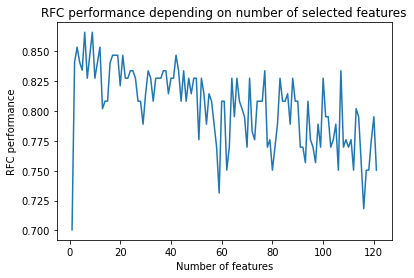

In [ ]:
# ranking the features based on RFE results

features_ranks = pd.DataFrame({'Features': features_non_intercorrelated, 'Ranks': selector.ranking_})
features_ranks.sort_values(by='Ranks', inplace = True)

# taking one best feature first, building the RFC, estimating the performance;
# adding +1 next feature, repeating the steps to estimate the performance

ftrs_number_tuning = []
acc_tuning = []

for i in range (1, len(features_ranks)):
    
    ftrs_number_tuning.append(i)
    estimator_tuning = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(0))
    estimator_tuning.fit(data_train[features_ranks['Features'][:i]], outcome_train)
    outcome_pred_tuning = estimator_tuning.predict(data_test[features_ranks['Features'][:i]])
    acc_tuning.append(balanced_accuracy_score(outcome_test, outcome_pred_tuning))
    
# plotting the results
plt.plot(ftrs_number_tuning, acc_tuning)
plt.xlabel('Number of features')
plt.ylabel('RFC performance')
plt.title('RFC performance depending on number of selected features')
plt.show()

What can we conclude from the plot? What are the downsides of the presented implementation? Is it correct to train and evaluate the model on the same samples? Is the selected performance metric correct? What other metrics can we use?

## Modeling



### MODEL 1: RFC

We started with RFC while performing RFE, so let us train this model with the selected features and evaluate in on test data.  

Training the model (it's possible to vary the parameters):

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(0))
rfc.fit(data_train[selected_features_set], outcome_train)

RandomForestClassifier()

Prediction for the testing set:

In [ ]:
outcome_pred_rfc = rfc.predict(data_test[selected_features_set])

Performance reporting on some key classification scores:

In [ ]:
print (classification_report(outcome_test, outcome_pred_rfc))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        80
           1       0.87      0.77      0.82        26

    accuracy                           0.92       106
   macro avg       0.90      0.87      0.88       106
weighted avg       0.91      0.92      0.91       106



Are precision and recall informative metrics? Why don't we report accuracy as a key metric? In which cases accuracy is not suitable scores?  
  
The other popular metric for classification is Receiver Operating Characteristic (ROC) curve and area under the curve (AUC). We will calculate true positive rates (TPR) and false positive rates (FPR) while varying classification threshold and plot the curve.

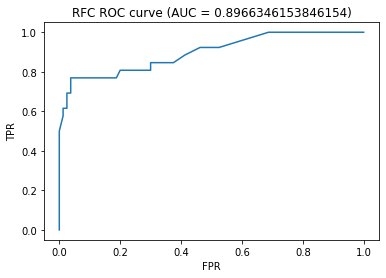

In [ ]:
fpr, tpr, _ = roc_curve(outcome_test, rfc.predict_proba(data_test[selected_features_set])[:, 1])
roc_auc = roc_auc_score(outcome_test, rfc.predict_proba(data_test[selected_features_set])[:, 1])

plt.plot(fpr, tpr)
plt.title('RFC ROC curve (AUC = {})'.format(roc_auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In which cases this metric does not give a correct representation of the model performance? Is AUC always the best metric?
Most cetainly not! Especially for unbalanced datasets, AUC can be meaningless. 
http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/
"With imbalanced classes, it’s easy to get a high accuracy without actually making useful predictions. So, accuracy as an evaluation metrics makes sense only if the class labels are uniformly distributed"    

To have a better understanding of model behaviour, we will plot a confusion matrix.

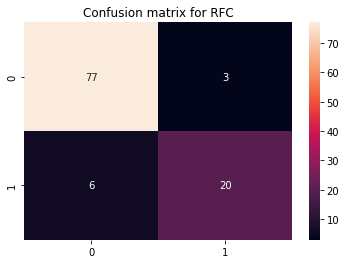

In [ ]:
cm = confusion_matrix(outcome_test, outcome_pred_rfc)
f = sns.heatmap(cm, annot=True)
plt.title('Confusion matrix for RFC')
plt.show()



### MODEL 2: XGBoost

The second model we will build is XGBoost because recently the algorithm was successfull in many machine learning competitions.

<b>XGBoost - what is it? It's always best to understand your models. </b>

https://xgboost.readthedocs.io/en/stable/python/python_intro.html#

Train the model: Here you can chose the max number of boosting iterations, a balance between computing time and accuracy.

Presenting the data in the appropriate format for the library.

In [ ]:
dtrain = xgb.DMatrix(data_train[selected_features_set], label=outcome_train)
dtest = xgb.DMatrix(data_test[selected_features_set], label=outcome_test)

Defining the parameters: the learning objective is logistic regression for binary classification with probability output, the metric is the area under precision-recall curve (why not ROC AUC?).

In [ ]:
param = {'objective': 'binary:logistic', 'eval_metric': 'aucpr'}

We will train the model on the training set and evaluate on test set.

In [ ]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

Training the model (number of iterations can be changed here!) and calculating outcomes for the test set.

In [ ]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

outcome_pred_xgb = bst.predict(dtest)

[0]	eval-aucpr:0.697929	train-aucpr:0.953898
[1]	eval-aucpr:0.764319	train-aucpr:0.980132
[2]	eval-aucpr:0.767598	train-aucpr:0.979338
[3]	eval-aucpr:0.790915	train-aucpr:0.986088
[4]	eval-aucpr:0.820544	train-aucpr:0.988672
[5]	eval-aucpr:0.812882	train-aucpr:0.992044
[6]	eval-aucpr:0.824588	train-aucpr:0.993079
[7]	eval-aucpr:0.820482	train-aucpr:0.99654
[8]	eval-aucpr:0.817885	train-aucpr:0.996786
[9]	eval-aucpr:0.817246	train-aucpr:0.998533


Classification report:

In [ ]:
print (classification_report(outcome_test, outcome_pred_xgb>0.5))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        80
           1       0.83      0.77      0.80        26

    accuracy                           0.91       106
   macro avg       0.88      0.86      0.87       106
weighted avg       0.90      0.91      0.90       106



ROC and ROC AUC:

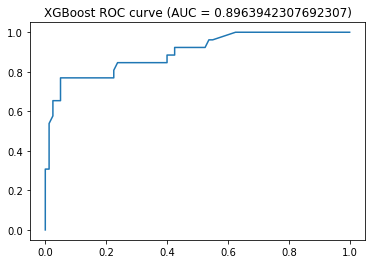

In [ ]:
fpr, tpr, _ = roc_curve(outcome_test, outcome_pred_xgb)
roc_auc = roc_auc_score(outcome_test, outcome_pred_xgb)

plt.plot(fpr, tpr)
plt.title('XGBoost ROC curve (AUC = {})'.format(roc_auc))
plt.show()

Create and display the confusion matrix and derived values for the Xgboost model.

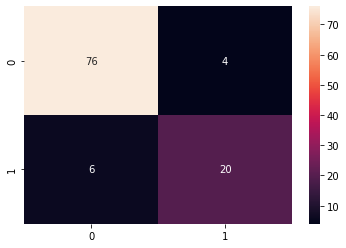

In [ ]:
cm = confusion_matrix(outcome_test, outcome_pred_xgb>0.5)
f = sns.heatmap(cm, annot=True)

<b>Almost done! You will now compare the performance of the models.</b>
  
Which classifier is better?  

To compare ROC AUC scores, we will perform a permuation test for the probabilities obtained on the test set for the both classifiers.

In [ ]:
# adapted from https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers
#-and-assess-statist

def permutation_test_between_clfs(y_test, pred_proba_1, pred_proba_2, nsamples=100):
    auc_differences = []
    auc1 = roc_auc_score(y_test.ravel(), pred_proba_1.ravel())
    auc2 = roc_auc_score(y_test.ravel(), pred_proba_2.ravel())
    observed_difference = auc1 - auc2
    for _ in range(nsamples):
        mask = np.random.randint(2, size=len(pred_proba_1.ravel()))
        p1 = np.where(mask, pred_proba_1.ravel(), pred_proba_2.ravel())
        p2 = np.where(mask, pred_proba_2.ravel(), pred_proba_1.ravel())
        auc1 = roc_auc_score(y_test.ravel(), p1)
        auc2 = roc_auc_score(y_test.ravel(), p2)
        auc_differences.append(auc1 - auc2)
    return observed_difference, np.mean(auc_differences >= observed_difference)

print ('Difference, p-value: ', 
       permutation_test_between_clfs(outcome_test,
                                     outcome_pred_xgb,
                                     rfc.predict_proba(data_test[selected_features_set])[:,1]))

Difference, p-value:  (-0.00024038461538467004, 0.52)


After this test, which classifier is better?  
  
After this you can go back and "finetune" the models by changing the parameters you feel comfortable with. See you can increase the model performance. Can you beat the othr groups?